<div align="center">

  <img src="https://raw.githubusercontent.com/The-RL-Hub/The-RL-Hub.github.io/main/Pictures/logo.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">The RLHub Notebook</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Value-Based Methods: Dynamic Programming</h2>

  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">July 2025</h3>

  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import datasets
from scipy.stats import poisson
import random

%matplotlib inline

import sys
print(f'Python version: {sys.version}')
np.random.seed(42)

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [ ]:
class DiscreteMDP:
    def __init__(self, states, actions, transitions, gamma=1.0):
        self.states = list(states)
        self.actions = actions
        self.transitions = transitions
        self.gamma = gamma

def value_iteration(mdp, theta=1e-6, max_iterations=1000):
    V = {s: 0.0 for s in mdp.states}
    for _ in range(max_iterations):
        delta = 0.0
        new_V = V.copy()
        for s in mdp.states:
            act_list = mdp.actions.get(s, [])
            if not act_list:
                continue
            values = []
            for a in act_list:
                total = 0.0
                for ns, p, r in mdp.transitions[(s, a)]:
                    total += p * (r + mdp.gamma * V[ns])
                values.append(total)
            best_val = max(values)
            delta = max(delta, abs(best_val - V[s]))
            new_V[s] = best_val
        V = new_V
        if delta < theta:
            break
    policy = {}
    for s in mdp.states:
        act_list = mdp.actions.get(s, [])
        if not act_list:
            policy[s] = None
            continue
        best_val = -1e9
        best_a = None
        for a in act_list:
            total = 0.0
            for ns, p, r in mdp.transitions[(s, a)]:
                total += p * (r + mdp.gamma * V[ns])
            if total > best_val:
                best_val = total
                best_a = a
        policy[s] = best_a
    return V, policy

def policy_evaluation(mdp, policy, theta=1e-6, max_iterations=1000):
    V = {s: 0.0 for s in mdp.states}
    for _ in range(max_iterations):
        delta = 0.0
        new_V = V.copy()
        for s in mdp.states:
            a = policy.get(s)
            if a is None:
                continue
            total = 0.0
            for ns, p, r in mdp.transitions[(s, a)]:
                total += p * (r + mdp.gamma * V[ns])
            delta = max(delta, abs(total - V[s]))
            new_V[s] = total
        V = new_V
        if delta < theta:
            break
    return V

def policy_iteration(mdp, theta=1e-6, max_iterations=1000):
    policy = {s: (mdp.actions[s][0] if mdp.actions[s] else None) for s in mdp.states}
    for _ in range(max_iterations):
        V = policy_evaluation(mdp, policy, theta, max_iterations)
        policy_stable = True
        for s in mdp.states:
            act_list = mdp.actions.get(s, [])
            if not act_list:
                continue
            old_action = policy[s]
            best_a = None
            best_val = -1e9
            for a in act_list:
                total = 0.0
                for ns, p, r in mdp.transitions[(s, a)]:
                    total += p * (r + mdp.gamma * V[ns])
                if total > best_val:
                    best_val = total
                    best_a = a
            policy[s] = best_a
            if best_a != old_action:
                policy_stable = False
        if policy_stable:
            break
    return V, policy

## Interactive Helper Functions
The following helper functions allow you to experiment with different MDP settings by changing parameters. Call them with your own parameters to see how values and policies change.

In [ ]:
def random_walk_example(num_states=6, reward_state=None, gamma=1.0):
    if reward_state is None:
        reward_state = num_states - 1
    states = list(range(num_states))
    actions = {s: ['left', 'right'] for s in states}
    actions[0] = []
    actions[num_states-1] = []
    trans = defaultdict(list)
    for s in range(1, num_states-1):
        trans[(s, 'left')].append((s-1, 1.0, 0.0))
        reward = 1.0 if s == reward_state - 1 else 0.0
        trans[(s, 'right')].append((s+1, 1.0, reward))
    mdp_local = DiscreteMDP(states, actions, trans, gamma=gamma)
    V, policy = value_iteration(mdp_local)
    print('Random walk values:', V)
    print('Random walk policy:', policy)
    return V, policy

def gridworld_example(size=4, gamma=1.0):
    states = list(range(size * size))
    actions = {s: ['up', 'down', 'left', 'right'] for s in states}
    terminal = [0, size * size - 1]
    for s in terminal:
        actions[s] = []
    trans = defaultdict(list)
    for r in range(size):
        for c in range(size):
            s = r * size + c
            if s in terminal:
                continue
            nr = max(r - 1, 0); ns = nr * size + c; trans[(s, 'up')].append((ns, 1.0, -1))
            nr = min(r + 1, size - 1); ns = nr * size + c; trans[(s, 'down')].append((ns, 1.0, -1))
            nc = max(c - 1, 0); ns = r * size + nc; trans[(s, 'left')].append((ns, 1.0, -1))
            nc = min(c + 1, size - 1); ns = r * size + nc; trans[(s, 'right')].append((ns, 1.0, -1))
    mdp_local = DiscreteMDP(states, actions, trans, gamma=gamma)
    V, policy = value_iteration(mdp_local)
    V_arr = np.array([V[s] for s in states]).reshape(size, size)
    plt.figure(figsize=(size, size))
    plt.imshow(V_arr, cmap='coolwarm', origin='upper')
    for (i, j), val in np.ndenumerate(V_arr):
        plt.text(j, i, f"{val:.0f}", ha='center', va='center', color='black')
    plt.title(f'{size}×{size} gridworld values')
    plt.colorbar()
    plt.show()
    return V, policy

def nchain_example(n=5, slip=0.1, gamma=0.9):
    states = list(range(n))
    actions = {s: ['forward', 'reset'] for s in states}
    trans = defaultdict(list)
    for s in states:
        if s == n - 1:
            trans[(s, 'forward')].append((s, 1.0 - slip, 1.0))
            trans[(s, 'forward')].append((0, slip, 1.0))
        else:
            trans[(s, 'forward')].append((s + 1, 1.0 - slip, 0.0))
            trans[(s, 'forward')].append((0, slip, 0.0))
        reward = 1.0 if s == n - 1 else 0.0
        trans[(s, 'reset')].append((0, 1.0, reward))
    mdp_local = DiscreteMDP(states, actions, trans, gamma=gamma)
    V, policy = value_iteration(mdp_local)
    print('N‑chain values:', V)
    print('N‑chain policy:', policy)
    return V, policy

def experiment_gamma(builder_func, gamma_values):
    start_values = []
    for g in gamma_values:
        mdp_local = builder_func(g)
        V, _ = value_iteration(mdp_local)
        start_values.append(V[list(mdp_local.states)[0]])
    plt.figure(figsize=(5, 3))
    plt.plot(gamma_values, start_values, marker='o')
    plt.xlabel('Gamma')
    plt.ylabel('Value of start state')
    plt.title('Effect of discount factor')
    plt.show()
    return start_values

## Example 1: Random Walk
A simple random walk with six states (0–5). States 0 and 5 are terminal. Reward of 1 is received when moving into state 5.


In [ ]:
states = list(range(6))
actions = {s: ['left', 'right'] for s in states}
actions[0] = []
actions[5] = []
transitions = defaultdict(list)
for s in range(1, 5):
    transitions[(s, 'left')].append((s-1, 1.0, 0.0))
    reward = 1.0 if s == 4 else 0.0
    transitions[(s, 'right')].append((s+1, 1.0, reward))
random_walk_mdp = DiscreteMDP(states, actions, transitions, gamma=1.0)
V_rw, policy_rw = value_iteration(random_walk_mdp)
print("Value function:", V_rw)
print("Policy:", policy_rw)

Value function: {0: 0.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.0}
Policy: {0: None, 1: 'right', 2: 'left', 3: 'left', 4: 'left', 5: None}


## Example 2: 4×4 Gridworld
A 4×4 grid with terminal states in the corners. Each step costs −1.


[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


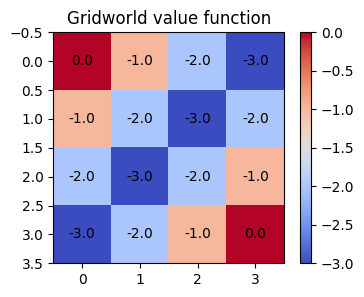

In [ ]:
def build_gridworld(n=4):
    states = list(range(n * n))
    actions = {s: ['up', 'down', 'left', 'right'] for s in states}
    terminal = [0, n * n - 1]
    for s in terminal:
        actions[s] = []
    trans = defaultdict(list)
    for r in range(n):
        for c in range(n):
            s = r * n + c
            if s in terminal:
                continue
            nr = max(r - 1, 0); ns = nr * n + c; trans[(s, 'up')].append((ns, 1.0, -1))
            nr = min(r + 1, n - 1); ns = nr * n + c; trans[(s, 'down')].append((ns, 1.0, -1))
            nc = max(c - 1, 0); ns = r * n + nc; trans[(s, 'left')].append((ns, 1.0, -1))
            nc = min(c + 1, n - 1); ns = r * n + nc; trans[(s, 'right')].append((ns, 1.0, -1))
    return DiscreteMDP(states, actions, trans, gamma=1.0)

grid_mdp = build_gridworld()
V_grid, policy_grid = value_iteration(grid_mdp, theta=1e-4)
V_array = np.array([V_grid[s] for s in grid_mdp.states]).reshape(4, 4)
print(V_array)
plt.figure(figsize=(4, 3))
plt.imshow(V_array, cmap='coolwarm', origin='upper')
for (i, j), val in np.ndenumerate(V_array):
    plt.text(j, i, round(val, 1), ha='center', va='center', color='black')
plt.title('Gridworld value function')
plt.colorbar()
plt.show()

## Example 3: Cliff Walking
A 4×12 grid with a start at the bottom-left, a goal at the bottom-right, and a cliff in between. Falling into the cliff yields −100; otherwise each move costs −1.


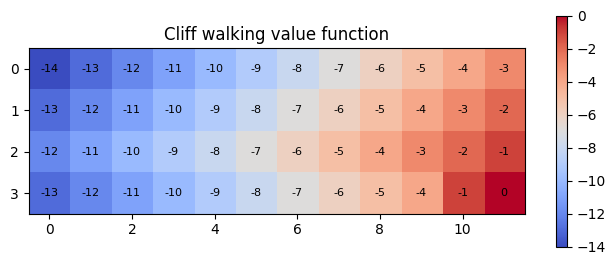

In [ ]:
def build_cliff_world(rows=4, cols=12):
    states = list(range(rows * cols))
    actions = {s: ['up', 'down', 'left', 'right'] for s in states}
    goal = (rows - 1) * cols + (cols - 1)
    start = (rows - 1) * cols + 0
    actions[goal] = []
    trans = defaultdict(list)
    for r in range(rows):
        for c in range(cols):
            s = r * cols + c
            if s == goal:
                continue
            for a in ['up', 'down', 'left', 'right']:
                nr, nc = r, c
                if a == 'up': nr = max(r - 1, 0)
                elif a == 'down': nr = min(r + 1, rows - 1)
                elif a == 'left': nc = max(c - 1, 0)
                elif a == 'right': nc = min(c + 1, cols - 1)
                ns = nr * cols + nc
                if nr == rows - 1 and 1 <= nc <= cols - 2 and ns != goal:
                    ns = start
                    reward = -100
                else:
                    reward = -1
                trans[(s, a)].append((ns, 1.0, reward))
    return DiscreteMDP(states, actions, trans, gamma=1.0)

cliff_mdp = build_cliff_world()
V_cliff, policy_cliff = value_iteration(cliff_mdp, theta=1e-3, max_iterations=2000)
val_array = np.array([V_cliff[s] for s in range(len(cliff_mdp.states))]).reshape(4, 12)
plt.figure(figsize=(8, 3))
plt.imshow(val_array, cmap='coolwarm', origin='upper')
for (i, j), val in np.ndenumerate(val_array):
    plt.text(j, i, round(val), ha='center', va='center', color='black', fontsize=8)
plt.title('Cliff walking value function')
plt.colorbar()
plt.show()

## Example 4: Gambler’s Problem
Capital levels from 0 to 100; the goal is to reach 100. Probability of a win is 0.4.


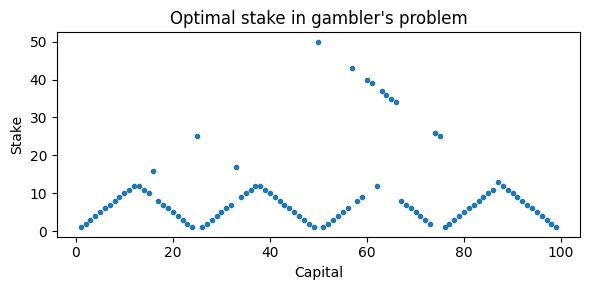

Converged in 15 iterations.


In [ ]:
def gambler_value_iteration(p=0.4, goal=100, theta=1e-8, max_iterations=100000):
    V = np.zeros(goal + 1, dtype=np.float64)
    V[goal] = 1.0

    policy = np.zeros(goal + 1, dtype=np.int64)

    for it in range(max_iterations):
        delta = 0.0
        for s in range(1, goal):
            max_stake = min(s, goal - s)
            if max_stake == 0:
                continue
            stakes = np.arange(1, max_stake + 1)

            win = s + stakes
            lose = s - stakes

            q = p * V[win] + (1.0 - p) * V[lose]

            best_idx = int(np.argmax(q))
            best_v = float(q[best_idx])

            delta = max(delta, abs(best_v - V[s]))
            V[s] = best_v
            policy[s] = int(stakes[best_idx])

        if delta < theta:
            return V, policy, it + 1

    return V, policy, max_iterations

p = 0.4
goal = 100
V, policy, iters = gambler_value_iteration(p=p, goal=goal, theta=1e-8)

capitals = np.arange(1, goal)
stakes = policy[1:goal]

plt.figure(figsize=(6, 3))
plt.plot(capitals, stakes, '.')
plt.xlabel('Capital')
plt.ylabel('Stake')
plt.title("Optimal stake in gambler's problem")
plt.tight_layout()
plt.show()

print(f"Converged in {iters} iterations.")

## Example 5: Inventory Control
A simplified rental problem with two locations, each with up to 3 cars. Rentals and returns follow Poisson distributions.


In [ ]:
def build_inventory(capacity=3, max_transfer=3, lambda_req=(2, 2), lambda_ret=(1, 1), max_poisson=3):
    states = [(i, j) for i in range(capacity + 1) for j in range(capacity + 1)]
    actions = {}
    trans = defaultdict(list)
    gamma = 0.9
    for s in states:
        a_min = -min(s[1], max_transfer)
        a_max = min(s[0], max_transfer)
        acts = list(range(a_min, a_max + 1))
        actions[s] = acts
        for a in acts:
            cars1 = s[0] - a
            cars2 = s[1] + a
            move_cost = 2 * abs(a)
            for req1 in range(0, max_poisson + 1):
                p_req1 = poisson.pmf(req1, lambda_req[0])
                for req2 in range(0, max_poisson + 1):
                    p_req2 = poisson.pmf(req2, lambda_req[1])
                    rent1 = min(cars1, req1)
                    rent2 = min(cars2, req2)
                    reward = 10 * (rent1 + rent2) - move_cost
                    cars1_after = cars1 - rent1
                    cars2_after = cars2 - rent2
                    for ret1 in range(0, max_poisson + 1):
                        p_ret1 = poisson.pmf(ret1, lambda_ret[0])
                        for ret2 in range(0, max_poisson + 1):
                            p_ret2 = poisson.pmf(ret2, lambda_ret[1])
                            prob = p_req1 * p_req2 * p_ret1 * p_ret2
                            new1 = min(cars1_after + ret1, capacity)
                            new2 = min(cars2_after + ret2, capacity)
                            ns = (new1, new2)
                            trans[((s[0], s[1]), a)].append((ns, prob, reward))
    return DiscreteMDP(states, actions, trans, gamma)

inv_mdp = build_inventory()
V_inv, policy_inv = value_iteration(inv_mdp, theta=1e-2, max_iterations=50)
for s in sorted(inv_mdp.states):
    if s[0] == 3:
        print(f"State {s}: move {policy_inv[s]} cars from loc1 to loc2")

State (3, 0): move 1 cars from loc1 to loc2
State (3, 1): move 1 cars from loc1 to loc2
State (3, 2): move 0 cars from loc1 to loc2
State (3, 3): move 0 cars from loc1 to loc2


## Example 6: Multi‑Armed Bandit
A one‑state MDP representing a three‑armed bandit. Each arm returns a reward drawn from a normal distribution.


In [ ]:
states = [0]
actions = {0: ['arm0', 'arm1', 'arm2']}
trans = defaultdict(list)
means = {0: 0.2, 1: 0.5, 2: 0.8}
for a_idx, a_name in enumerate(['arm0', 'arm1', 'arm2']):
    trans[(0, a_name)].append((0, 1.0, means[a_idx]))
bandit_mdp = DiscreteMDP(states, actions, trans, gamma=0.9)
V_bandit, policy_bandit = value_iteration(bandit_mdp)
print("Bandit value:", V_bandit)
print("Best arm:", policy_bandit[0])

Bandit value: {0: 7.999991893027057}
Best arm: arm2


## Example 7: Classification as Bandit
Using the Iris dataset, each sample is a state. Actions correspond to predicting one of three classes. Reward is 1 for a correct prediction and 0 otherwise.


In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
states = list(range(len(X)))
actions = {s: [0, 1, 2] for s in states}
trans = defaultdict(list)
for s in states:
    for a in actions[s]:
        reward = 1.0 if a == y[s] else 0.0
        trans[(s, a)].append((s, 1.0, reward))
cls_mdp = DiscreteMDP(states, actions, trans, gamma=1.0)
import random
random_policy = {s: random.choice(actions[s]) for s in states}
V_rand = policy_evaluation(cls_mdp, random_policy)
avg_rand = np.mean([V_rand[s] for s in states])
greedy_policy = {s: int(y[s]) for s in states}
V_greedy = policy_evaluation(cls_mdp, greedy_policy)
avg_greedy = np.mean([V_greedy[s] for s in states])
print(f"Average reward with random policy: {avg_rand:.2f}")
print(f"Average reward with greedy policy: {avg_greedy:.2f}")

Average reward with random policy: 326.67
Average reward with greedy policy: 1000.00


## Example 8: N‑Chain
A chain of five states with a slip probability. The agent can move forward or reset to the start. Reward of 1 is received at the far end.


In [ ]:
def build_nchain(n=5, slip=0.1):
    states = list(range(n))
    actions = {s: ['forward', 'reset'] for s in states}
    trans = defaultdict(list)
    for s in states:
        if s == n - 1:
            trans[(s, 'forward')].append((s, 1.0 - slip, 1.0))
            trans[(s, 'forward')].append((0, slip, 1.0))
        else:
            trans[(s, 'forward')].append((s + 1, 1.0 - slip, 0.0))
            trans[(s, 'forward')].append((0, slip, 0.0))
        if s == n - 1:
            reward = 1.0
        else:
            reward = 0.0
        trans[(s, 'reset')].append((0, 1.0, reward))
    return DiscreteMDP(states, actions, trans, gamma=0.9)

nchain_mdp = build_nchain(n=5, slip=0.2)
V_chain, policy_chain = value_iteration(nchain_mdp)
print('N‑Chain value function:', V_chain)
print('N‑Chain policy:', policy_chain)

N‑Chain value function: {0: 2.6873769217707557, 1: 3.060624921770755, 2: 3.5790249217707557, 3: 4.299024921770755, 4: 5.299024921770756}
N‑Chain policy: {0: 'forward', 1: 'forward', 2: 'forward', 3: 'forward', 4: 'forward'}


## Example 9: Maze
A 5×5 maze with walls. The agent starts at the bottom‑left and aims to reach the top‑right. Walls are impassable. Each step costs −1 and reaching the goal yields +10.


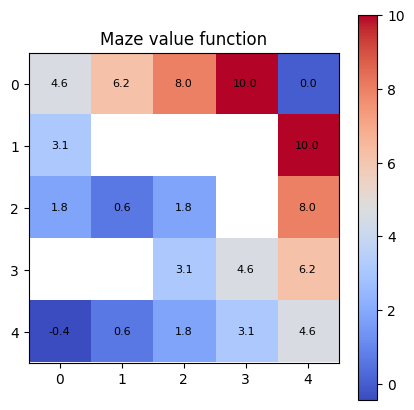

In [ ]:
def build_maze():
    maze = np.array([[0, 0, 0, 0, 0],
                     [0, 1, 1, 1, 0],
                     [0, 0, 0, 1, 0],
                     [1, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0]])
    rows, cols = maze.shape
    states = [(r, c) for r in range(rows) for c in range(cols) if maze[r, c] == 0]
    actions = {}
    trans = defaultdict(list)
    goal = (0, cols - 1)
    for s in states:
        actions[s] = ['up', 'down', 'left', 'right']
        if s == goal:
            actions[s] = []
            continue
        r, c = s
        for a in ['up', 'down', 'left', 'right']:
            nr, nc = r, c
            if a == 'up': nr = max(r - 1, 0)
            elif a == 'down': nr = min(r + 1, rows - 1)
            elif a == 'left': nc = max(c - 1, 0)
            elif a == 'right': nc = min(c + 1, cols - 1)
            if maze[nr, nc] == 1:
                nr, nc = r, c
            ns = (nr, nc)
            reward = 10.0 if ns == goal else -1.0
            trans[(s, a)].append((ns, 1.0, reward))
    return DiscreteMDP(states, actions, trans, gamma=0.9), goal

maze_mdp, goal_pos = build_maze()
V_maze, policy_maze = value_iteration(maze_mdp, theta=1e-3)
val_grid = np.full_like(np.zeros((5, 5)), np.nan, dtype=float)
for (r, c), v in V_maze.items():
    val_grid[r, c] = v
plt.figure(figsize=(5, 5))
plt.imshow(val_grid, cmap='coolwarm', origin='upper')
for r in range(5):
    for c in range(5):
        if not np.isnan(val_grid[r, c]):
            plt.text(c, r, f"{val_grid[r, c]:.1f}", ha='center', va='center', color='black', fontsize=8)
plt.title('Maze value function')
plt.colorbar()
plt.show()


## Example 10: Weather Decision
A simple weather model with three states (Sunny, Cloudy, Rainy). The decision is whether to go outside or stay inside. Rewards depend on the weather and the action.


In [ ]:
def build_weather_mdp():
    states = ['Sunny', 'Cloudy', 'Rainy']
    actions = {s: ['outside', 'inside'] for s in states}
    trans = defaultdict(list)
    T = {
        'Sunny': {'Sunny': 0.7, 'Cloudy': 0.2, 'Rainy': 0.1},
        'Cloudy': {'Sunny': 0.4, 'Cloudy': 0.4, 'Rainy': 0.2},
        'Rainy': {'Sunny': 0.3, 'Cloudy': 0.4, 'Rainy': 0.3}
    }
    R = {
        'outside': {'Sunny': 2.0, 'Cloudy': 1.0, 'Rainy': -1.0},
        'inside': {'Sunny': 0.5, 'Cloudy': 0.5, 'Rainy': 1.0}
    }
    for s in states:
        for a in actions[s]:
            for ns, p in T[s].items():
                reward = R[a][s]
                trans[(s, a)].append((ns, p, reward))
    return DiscreteMDP(states, actions, trans, gamma=0.9)

weather_mdp = build_weather_mdp()
V_weather, policy_weather = value_iteration(weather_mdp)
print('Weather value function:', V_weather)
print('Weather policy:', policy_weather)

Weather value function: {'Sunny': 16.132268406099097, 'Cloudy': 14.745496080588584, 'Rainy': 14.60834277366996}
Weather policy: {'Sunny': 'outside', 'Cloudy': 'outside', 'Rainy': 'inside'}


## Example 11: Wine Dataset
The Wine dataset has three classes. Each sample is a state; actions correspond to predicting one of the wine classes.

In [ ]:
wine = datasets.load_wine()
X_wine = wine.data
y_wine = wine.target
states_wine = list(range(len(X_wine)))
actions_wine = {s: list(range(3)) for s in states_wine}
trans_wine = defaultdict(list)
for s in states_wine:
    for a in actions_wine[s]:
        reward = 1.0 if a == y_wine[s] else 0.0
        trans_wine[(s, a)].append((s, 1.0, reward))
wine_mdp = DiscreteMDP(states_wine, actions_wine, trans_wine, gamma=1.0)
random_policy_wine = {s: random.choice(actions_wine[s]) for s in states_wine}
V_rand_wine = policy_evaluation(wine_mdp, random_policy_wine)
random_avg = np.mean([V_rand_wine[s] for s in states_wine])
greedy_policy_wine = {s: int(y_wine[s]) for s in states_wine}
V_greedy_wine = policy_evaluation(wine_mdp, greedy_policy_wine)
greedy_avg = np.mean([V_greedy_wine[s] for s in states_wine])
print(f"Wine: average reward random policy {random_avg:.2f}")
print(f"Wine: average reward greedy policy {greedy_avg:.2f}")

Wine: average reward random policy 303.37
Wine: average reward greedy policy 1000.00


## Example 12: Digits Dataset
The Digits dataset contains images of handwritten digits (0–9). We treat each image as a state and predicting its label as the action.

In [ ]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target
states_digits = list(range(len(X_digits)))
actions_digits = {s: list(range(10)) for s in states_digits}
trans_digits = defaultdict(list)
for s in states_digits:
    for a in actions_digits[s]:
        reward = 1.0 if a == y_digits[s] else 0.0
        trans_digits[(s, a)].append((s, 1.0, reward))
digits_mdp = DiscreteMDP(states_digits, actions_digits, trans_digits, gamma=1.0)


random_policy_digits = {s: random.choice(actions_digits[s]) for s in states_digits}
V_rand_digits = policy_evaluation(digits_mdp, random_policy_digits)
random_avg = np.mean([V_rand_digits[s] for s in states_digits])
greedy_policy_digits = {s: int(y_digits[s]) for s in states_digits}
V_greedy_digits = policy_evaluation(digits_mdp, greedy_policy_digits)
greedy_avg = np.mean([V_greedy_digits[s] for s in states_digits])
print(f"Digits: average reward random policy {random_avg:.2f}")
print(f"Digits: average reward greedy policy {greedy_avg:.2f}")

Digits: average reward random policy 100.72
Digits: average reward greedy policy 1000.00


## Example 13: Windy Gridworld
A wind blows the agent upward in certain columns. We compare value iteration and policy iteration on this environment and plot convergence.

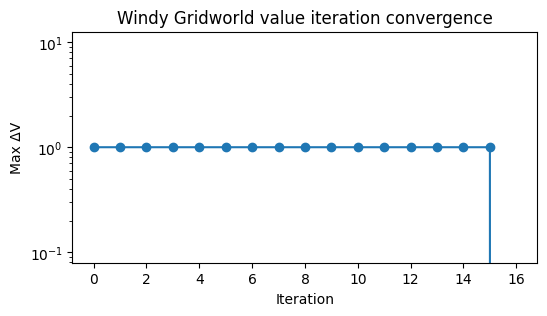

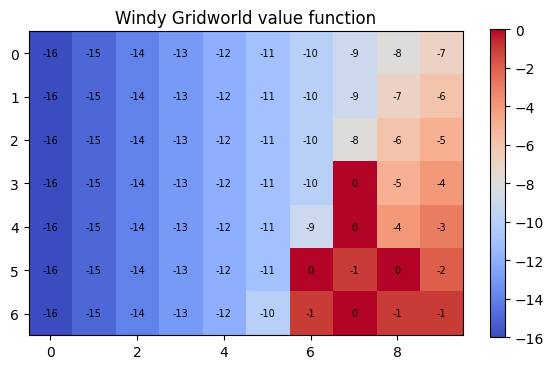

Value iteration steps: 17 iterations
Policy iteration sweeps: 18 sweeps


In [ ]:
def build_windy(rows=7, cols=10):
    wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    states = [(r, c) for r in range(rows) for c in range(cols)]
    actions = {}
    trans = defaultdict(list)
    start = (3, 0)
    goal = (3, 7)
    for s in states:
        if s == goal:
            actions[s] = []
            continue
        actions[s] = ['up', 'down', 'left', 'right']
        r, c = s
        for a in actions[s]:
            nr, nc = r, c
            if a == 'up': nr = max(r - 1, 0)
            elif a == 'down': nr = min(r + 1, rows - 1)
            elif a == 'left': nc = max(c - 1, 0)
            elif a == 'right': nc = min(c + 1, cols - 1)
            nr = max(nr - wind[nc], 0)
            ns = (nr, nc)
            reward = 0.0 if ns == goal else -1.0
            trans[(s, a)].append((ns, 1.0, reward))
    return DiscreteMDP(states, actions, trans, gamma=1.0), start, goal

windy_mdp, windy_start, windy_goal = build_windy()
def value_iteration_with_deltas(mdp, theta=1e-4, max_iter=1000):
    V = {s: 0.0 for s in mdp.states}
    deltas = []
    for _ in range(max_iter):
        delta = 0.0
        new_V = V.copy()
        for s in mdp.states:
            act_list = mdp.actions.get(s, [])
            if not act_list:
                continue
            values = []
            for a in act_list:
                total = 0.0
                for ns, p, r in mdp.transitions[(s, a)]:
                    total += p * (r + mdp.gamma * V[ns])
                values.append(total)
            best_val = max(values)
            delta = max(delta, abs(best_val - V[s]))
            new_V[s] = best_val
        V = new_V
        deltas.append(delta)
        if delta < theta:
            break
    policy = {}
    for s in mdp.states:
        act_list = mdp.actions.get(s, [])
        if not act_list:
            policy[s] = None
            continue
        best_val = -1e9
        best_a = None
        for a in act_list:
            total = sum(p * (r + mdp.gamma * V[ns]) for ns, p, r in mdp.transitions[(s, a)])
            if total > best_val:
                best_val = total
                best_a = a
        policy[s] = best_a
    return V, policy, deltas

def policy_iteration_steps(mdp, theta=1e-6, max_iter=100):
    policy = {s: (mdp.actions[s][0] if mdp.actions[s] else None) for s in mdp.states}
    steps = 0
    for _ in range(max_iter):
        V = policy_evaluation(mdp, policy, theta, max_iter)
        policy_stable = True
        steps += 1
        for s in mdp.states:
            act_list = mdp.actions.get(s, [])
            if not act_list:
                continue
            old_action = policy[s]
            best_a = None; best_val = -1e9
            for a in act_list:
                total = sum(p * (r + mdp.gamma * V[ns]) for ns, p, r in mdp.transitions[(s, a)])
                if total > best_val:
                    best_val = total; best_a = a
            policy[s] = best_a
            if best_a != old_action:
                policy_stable = False
        if policy_stable:
            break
    return steps

V_windy, policy_windy, deltas = value_iteration_with_deltas(windy_mdp, theta=1e-3)
policy_steps = policy_iteration_steps(windy_mdp)
plt.figure(figsize=(6, 3))
plt.plot(deltas, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Max ΔV')
plt.title('Windy Gridworld value iteration convergence')
plt.yscale('log')
plt.show()
val_matrix = np.full((7, 10), np.nan)
for s, v in V_windy.items():
    val_matrix[s[0], s[1]] = v
plt.figure(figsize=(7, 4))
plt.imshow(val_matrix, cmap='coolwarm', origin='upper')
for r in range(7):
    for c in range(10):
        if not np.isnan(val_matrix[r, c]):
            plt.text(c, r, f"{val_matrix[r, c]:.0f}", ha='center', va='center', fontsize=7)
plt.title('Windy Gridworld value function')
plt.colorbar()
plt.show()
print(f"Value iteration steps: {len(deltas)} iterations")
print(f"Policy iteration sweeps: {policy_steps} sweeps")

## Example 14: Infection Control
Control the spread of an infection. States represent infection level (0–10). Actions are no action or intervention; costs and transition probabilities vary with action. We plot the resulting value function and optimal policy.

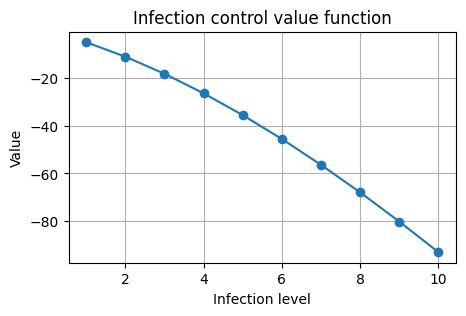

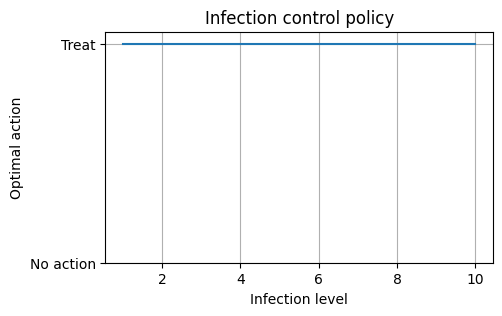

In [ ]:
def build_infection(p_up=0.6, p_down=0.1, p_down_treat=0.6, cost_treat=2.0):
    states = list(range(11))
    actions = {s: ([0, 1] if s > 0 else []) for s in states}
    trans = defaultdict(list)
    for s in states:
        if s == 0:
            actions[s] = []
            continue
        total_prob = 0.0
        ns = min(s + 1, 10)
        trans[(s, 0)].append((ns, p_up, -float(s)))
        ns = max(s - 1, 0)
        trans[(s, 0)].append((ns, p_down, -float(s)))
        trans[(s, 0)].append((s, 1.0 - p_up - p_down, -float(s)))
        ns = max(s - 1, 0)
        trans[(s, 1)].append((ns, p_down_treat, -float(s) - cost_treat))
        trans[(s, 1)].append((s, 1.0 - p_down_treat, -float(s) - cost_treat))
    return DiscreteMDP(states, actions, trans, gamma=0.95)

infect_mdp = build_infection()
V_inf, policy_inf = value_iteration(infect_mdp, theta=1e-4)
levels = np.array(list(range(1, 11)))
values = [V_inf[l] for l in levels]
plt.figure(figsize=(5, 3))
plt.plot(levels, values, marker='o')
plt.xlabel('Infection level')
plt.ylabel('Value')
plt.title('Infection control value function')
plt.grid(True)
plt.show()
actions_plot = [policy_inf[l] for l in levels]
plt.figure(figsize=(5, 3))
plt.step(levels, actions_plot, where='post')
plt.yticks([0, 1], ['No action', 'Treat'])
plt.xlabel('Infection level')
plt.ylabel('Optimal action')
plt.title('Infection control policy')
plt.grid(True)
plt.show()

## Example 15: Comparing Classification Datasets
We compare the average reward of random and greedy policies on the Iris, Wine and Digits datasets.

  Dataset      Random  Greedy
0    Iris  300.000000  1000.0
1    Wine  258.426966  1000.0
2  Digits   91.819699  1000.0


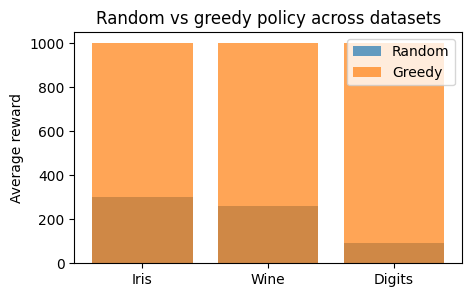

In [ ]:
def compute_average(dataset_loader, num_classes):
    data = dataset_loader()
    Xd, yd = data.data, data.target
    states = list(range(len(Xd)))
    actions = {s: list(range(num_classes)) for s in states}
    trans_local = defaultdict(list)
    for s in states:
        for a in actions[s]:
            reward = 1.0 if a == yd[s] else 0.0
            trans_local[(s, a)].append((s, 1.0, reward))
    mdp_local = DiscreteMDP(states, actions, trans_local, gamma=1.0)
    import random
    random_policy = {s: random.choice(actions[s]) for s in states}
    V_rand = policy_evaluation(mdp_local, random_policy)
    greedy_policy = {s: int(yd[s]) for s in states}
    V_greedy = policy_evaluation(mdp_local, greedy_policy)
    avg_rand = np.mean([V_rand[s] for s in states])
    avg_greedy = np.mean([V_greedy[s] for s in states])
    return avg_rand, avg_greedy

iris_rand, iris_greedy = compute_average(datasets.load_iris, 3)
wine_rand, wine_greedy = compute_average(datasets.load_wine, 3)
digits_rand, digits_greedy = compute_average(datasets.load_digits, 10)
import pandas as pd
results = pd.DataFrame({
    'Dataset': ['Iris', 'Wine', 'Digits'],
    'Random': [iris_rand, wine_rand, digits_rand],
    'Greedy': [iris_greedy, wine_greedy, digits_greedy]
})
print(results)
results_melt = results.melt(id_vars='Dataset', var_name='Policy', value_name='Average reward')
plt.figure(figsize=(5, 3))
for policy in ['Random', 'Greedy']:
    subset = results_melt[results_melt['Policy'] == policy]
    plt.bar(subset['Dataset'], subset['Average reward'], alpha=0.7, label=policy)
plt.legend()
plt.ylabel('Average reward')
plt.title('Random vs greedy policy across datasets')
plt.show()